# Zadanie 2
## Obraz binarny

In [57]:
import imageio

from matplotlib import pyplot as plt
from matplotlib import cm

from random import random, randrange

## Matter representation
Matter is represented as an array with boolean values (later called colors).

## Energy function
Energy is defined as a matrix with an odd-number of columns and rows. The central element is always zero and it represents the point for which we are calculating the energy. Every other element is mapped to the matter array and is multiplied by (-1) when is of different color and by 1 when the same. The resulting sum is an energy of a point. Total energy will be the sum of energies of each point.

In [58]:
# Implemented energy functions

philia = [
    [0, -1, 0],
    [-1, 0, -1],
    [0, -1, 0]
]
phobia = [
    [0, 1, 0],
    [1, 0, 1],
    [0, 1, 0]
]
horizontal = [
    [1, 1, 1],
    [-1, 0, -1],
    [1, 1, 1]
]
diagonal = [
    [-1, 0.5, 1],
    [-0.5, 0, -0.5],
    [1, 0.5, -1]
]
grid = [
    [-1, 0, -1, 0, -1],
    [0, 1, 0, 1, 0],
    [-1, 0, 0, 0, -1],
    [0, 1, 0, 1, 0],
    [-1, 0, -1, 0, -1],
]
cubic = [
    [1, 0.5, -0.5, 0.5, 1],
    [0.5, -0.5, -1, -0.5, 0.5],
    [-0.5, -1, 0, -1, -0.5],
    [0.5, -0.5, -1, -0.5, 0.5],
    [1, 0.5, -0.5, 0.5, 1],
]

Functions that calculate single cell energy and energy of the whole system

In [59]:
def calculate_cell_energy(point, matter, energy_system):
    mat_x, mat_y = len(matter[0]), len(matter)
    r_y = len(energy_system) // 2
    r_x = len(energy_system[0]) // 2

    x, y = point
    element = matter[y][x]
    energy = 0
    for dy in range(-r_y, r_y + 1):
        for dx in range(-r_x, r_x + 1):
            if 0 <= y+dy < mat_y and 0 <= x+dx < mat_x and (dy != 0 or dx != 0):
                energy += (1 if matter[y+dy][x+dx] == element else -1) * energy_system[r_y + dy][r_x + dx]
    return energy

def calculate_total_energy(matter, energy_system):
    mat_x, mat_y = len(matter[0]), len(matter)

    energy = 0
    for y in range(mat_y):
        for x in range(mat_x):
            energy += calculate_cell_energy(point=(x, y), matter=matter, energy_system=energy_system)
    return energy

This function swaps two points (passed in points_changed) and returns the energy difference resulted from this swap

In [60]:
# Returns energy difference
def update_matter(matter, energy_system, points_changed):
    mat_x, mat_y = len(matter[0]), len(matter)
    r_y = len(energy_system) // 2
    r_x = len(energy_system[0]) // 2

    delta_energy = 0
    for (x, y) in points_changed:
        for dy in range(-r_y, r_y + 1):
            for dx in range(-r_x, r_x + 1):
                if 0 <= y+dy < mat_y and 0 <= x+dx < mat_x:
                    delta_energy -= calculate_cell_energy((x+dx, y+dy), matter, energy_system)

    for (x, y) in points_changed:
        matter[y][x] = not matter[y][x]

    for (x, y) in points_changed:
        for dy in range(-r_y, r_y + 1):
            for dx in range(-r_x, r_x + 1):
                if 0 <= y+dy < mat_y and 0 <= x+dx < mat_x:
                    delta_energy += calculate_cell_energy((x+dx, y+dy), matter, energy_system)

    return delta_energy

Function that returns random matter array with given size and share of black points

In [61]:
def generate_random_matter(size=(10, 20), share=0.5):
    return [
        [
            random() > share for _ in range(size[1])
        ] for _ in range(size[0])
    ]

In [62]:
def get_two_random_contrary_points(matter):
    max_x, max_y = len(matter[0]), len(matter)
    while True:
        x1, x2 = [randrange(max_x) for _ in range(2)]
        y1, y2 = [randrange(max_y) for _ in range(2)]
        if matter[y1][x1] != matter[y2][x2]:
            return (x1, y1), (x2, y2)

### Simulation function
The simulation will have given number of iterations.
The temperature is represented by the function:
*y = a ^i^*
where *a* is *temp_exponent* parameter.
In each iteration the neibouring state is generated. If it's energy is lower, then the state always accepted. Otherwise, it is determined by the current temperature, *acceptance_factor* parameter and a random factor. If state is not accepted, then the changes are reverted. One per *save_one_in_n_frames* states is saved as a *.png* for *.gif* file to be generated later.

In [63]:
def simulation(matter, energy_system, iterations, temp_exponent=0.95, acceptance_factor=50, save_one_in_n_frames=None):
    results = []
    current_energy = calculate_total_energy(matter, energy_system)
    frame_index = 0

    temperature = 1

    for i in range(iterations):
        (x1, y1), (x2, y2) = get_two_random_contrary_points(matter)

        temperature *= temp_exponent
        new_energy = current_energy + update_matter(matter, energy_system, points_changed=[(x1, y1), (x2, y2)])

        if (new_energy - current_energy) * random() < acceptance_factor * temperature:
            current_energy = new_energy
        # Revert changes
        else:
            matter[y1][x1], matter[y2][x2] = matter[y2][x2], matter[y1][x1]

        if save_one_in_n_frames is not None and i % save_one_in_n_frames == 0:
            plt.imshow(matter, interpolation='nearest', cmap=cm.Greys_r)
            plt.savefig(f'./tmp/task2/img_{frame_index}.png',
                transparent = False,
                facecolor = 'white'
               )
            plt.close()
            frame_index += 1

        results.append(current_energy)
    return results, frame_index

In [64]:
def create_gif(frames_number, looping=False):
    frames = []
    for i in range(frames_number):
        image = imageio.v2.imread(f'./tmp/Task2/img_{i}.png')
        frames.append(image)

    imageio.mimsave('./example.gif', ims=frames, fps = 5, loop=0 if looping else 1)

# Examples
#### "Philia" grid
Energy is lower when the same colors are next to each other

![title](examples/Task2/philia_chart.png)
![title](examples/Task2/philia.gif)

#### "Phobia" grid
Energy is higher when the same colors are next to each other

![title](examples/Task2/phobia_chart.png)
![title](examples/Task2/phobia.gif)

#### "Diagonal" grid
Energy is lower when the same colors are on the one diagonal and higher when on the other

![title](examples/Task2/diagonal_chart.png)
![title](examples/Task2/diagonal.gif)

#### "Grid" grid
Energy is lower when the same colors are in the row or column next to the other color row/column

![title](examples/Task2/grid_chart.png)
![title](examples/Task2/grid.gif)

#### "Cubic" grid
Energy is lower when the same colors are next to each other, but one slot further is the other color

![title](examples/Task2/cubic_chart.png)
![title](examples/Task2/cubic.gif)

### Code to generate simulations
Result will be saved as *example.gif*

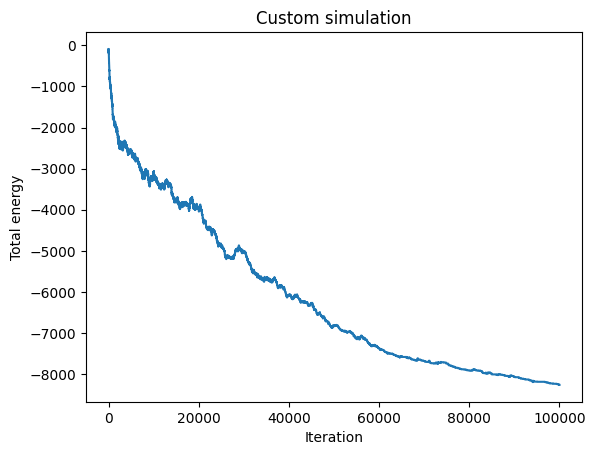

In [65]:
matter = generate_random_matter(
    size=(50, 50), share=0.5
)
results, frames_number = simulation(
    matter, iterations=100_000, temp_exponent=0.99993, acceptance_factor=3, save_one_in_n_frames=4000,
    energy_system=philia
    # energy_system=phobia
    # energy_system=diagonal
    # energy_system=grid
    # energy_system=cubic
)

plt.plot([i for i in range(len(results))], results)
plt.title("Custom simulation")
plt.xlabel("Iteration")
plt.ylabel("Total energy")

create_gif(frames_number, looping=False)